# Metrics investigation and workspace
This notebook allows to both:
- investigate the existing metrics on the given dataset
- develop new metrics and see the results live
- visualise metrics as plots


In [1]:
import importlib
from functools import partial
from utils import *

root_dir = add_root_to_path(3)

import skimage.morphology
import sep.inspect.regions as regions_inspect
import sep.inspect.metrics as metrics_inspect
import sep.assessors.regions as regions
import sep.assessors.regions as regions
import sep._commons.visuals as visuals

## Prepare dataset

In [2]:
import sep.loaders.images
data_root = pick_path([root_dir / "tests" / "input" / "basics"])
dataset = data_root / "lights"
data_loader = sep.loaders.images.ImagesLoader.from_tree(str(dataset))

{'id': 0}


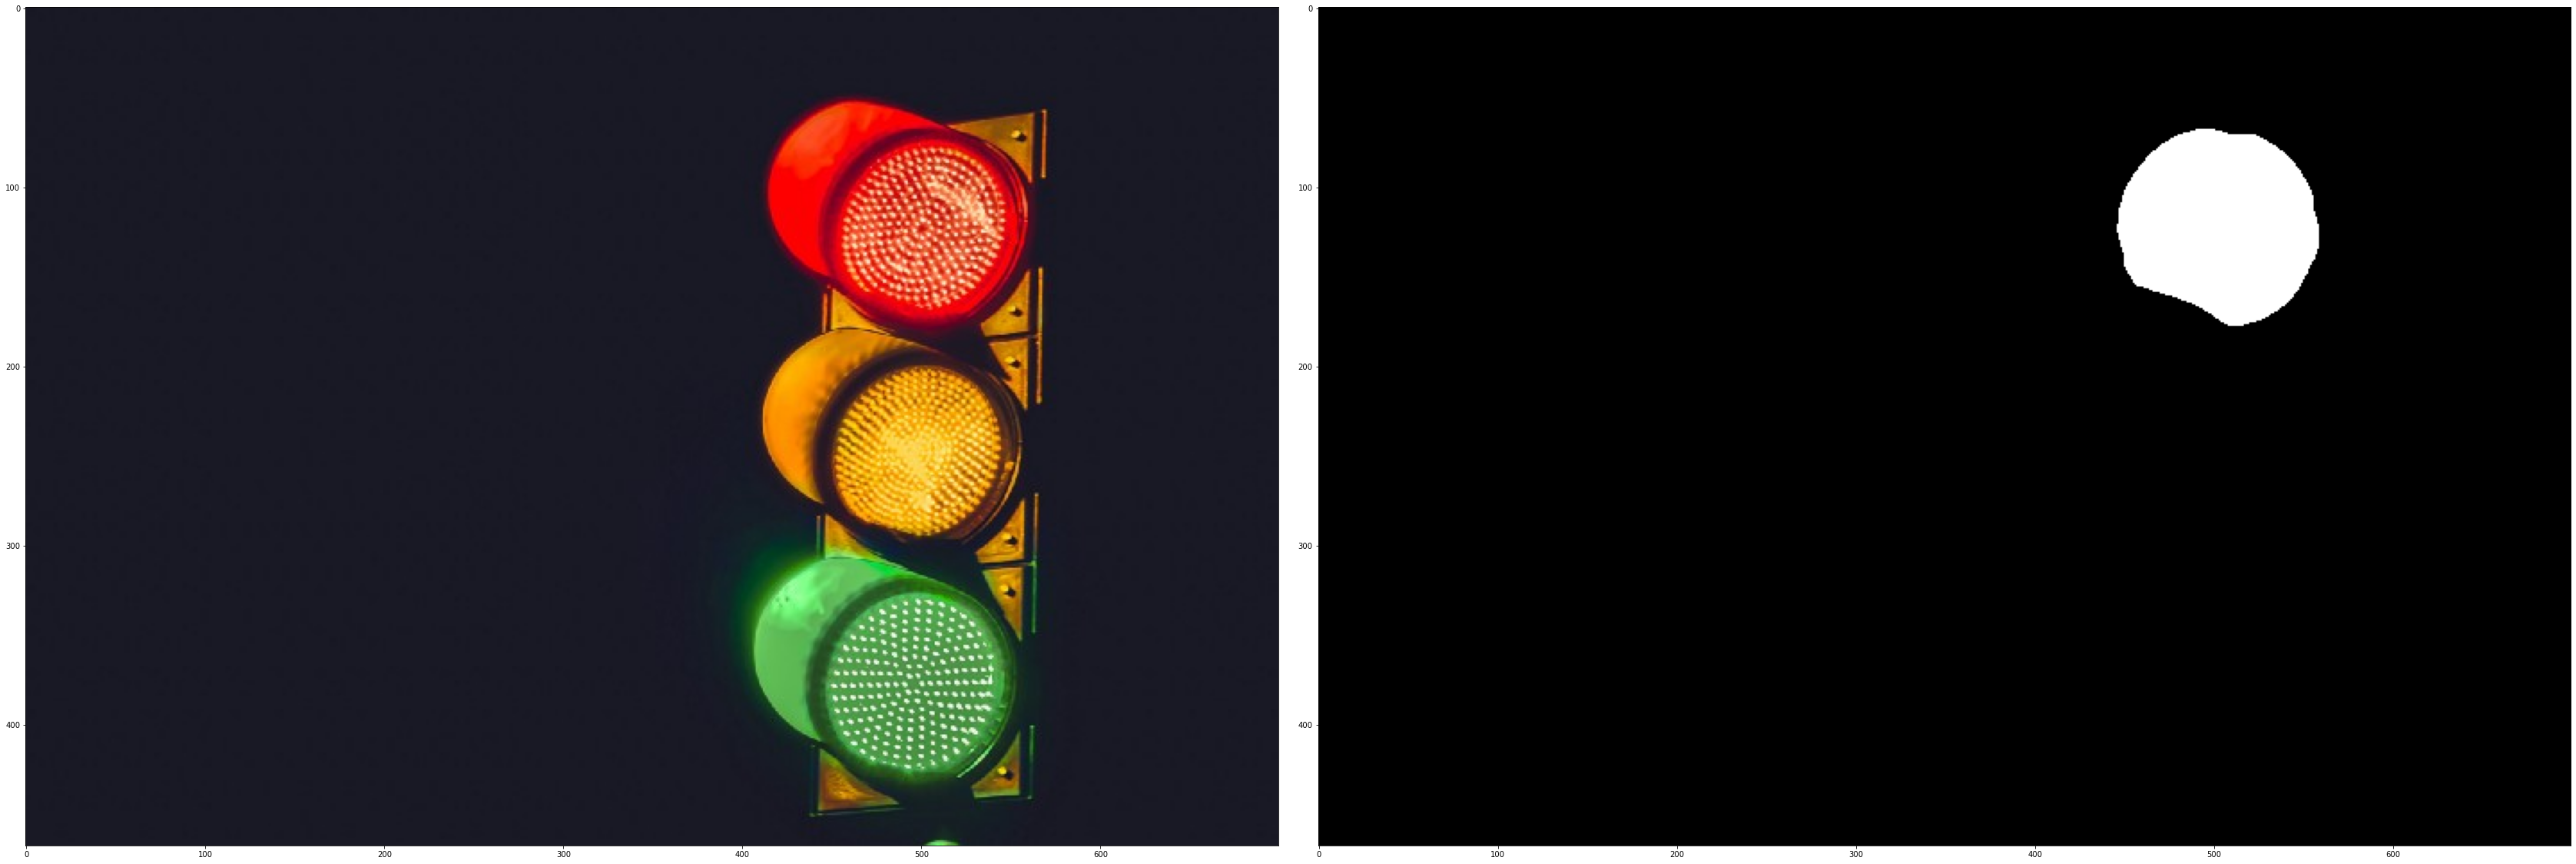

In [3]:
image = data_loader[0]['image']
annotation = data_loader[0]['annotation']
tag = data_loader[0]['tag']
print(tag)
show_all(1, 2, image, annotation);

## Prepare simple segmentator
Create threshold based colour segmentator that implements Producer interface and generate really bad red light segmentation.

{'run_time': 0.01805582499999936, 'run_fps': 55.38, 'producer_name': 'Reds', 'producer_details': "<class '__main__.RedsProducer'> ({'name': 'Reds'})"}


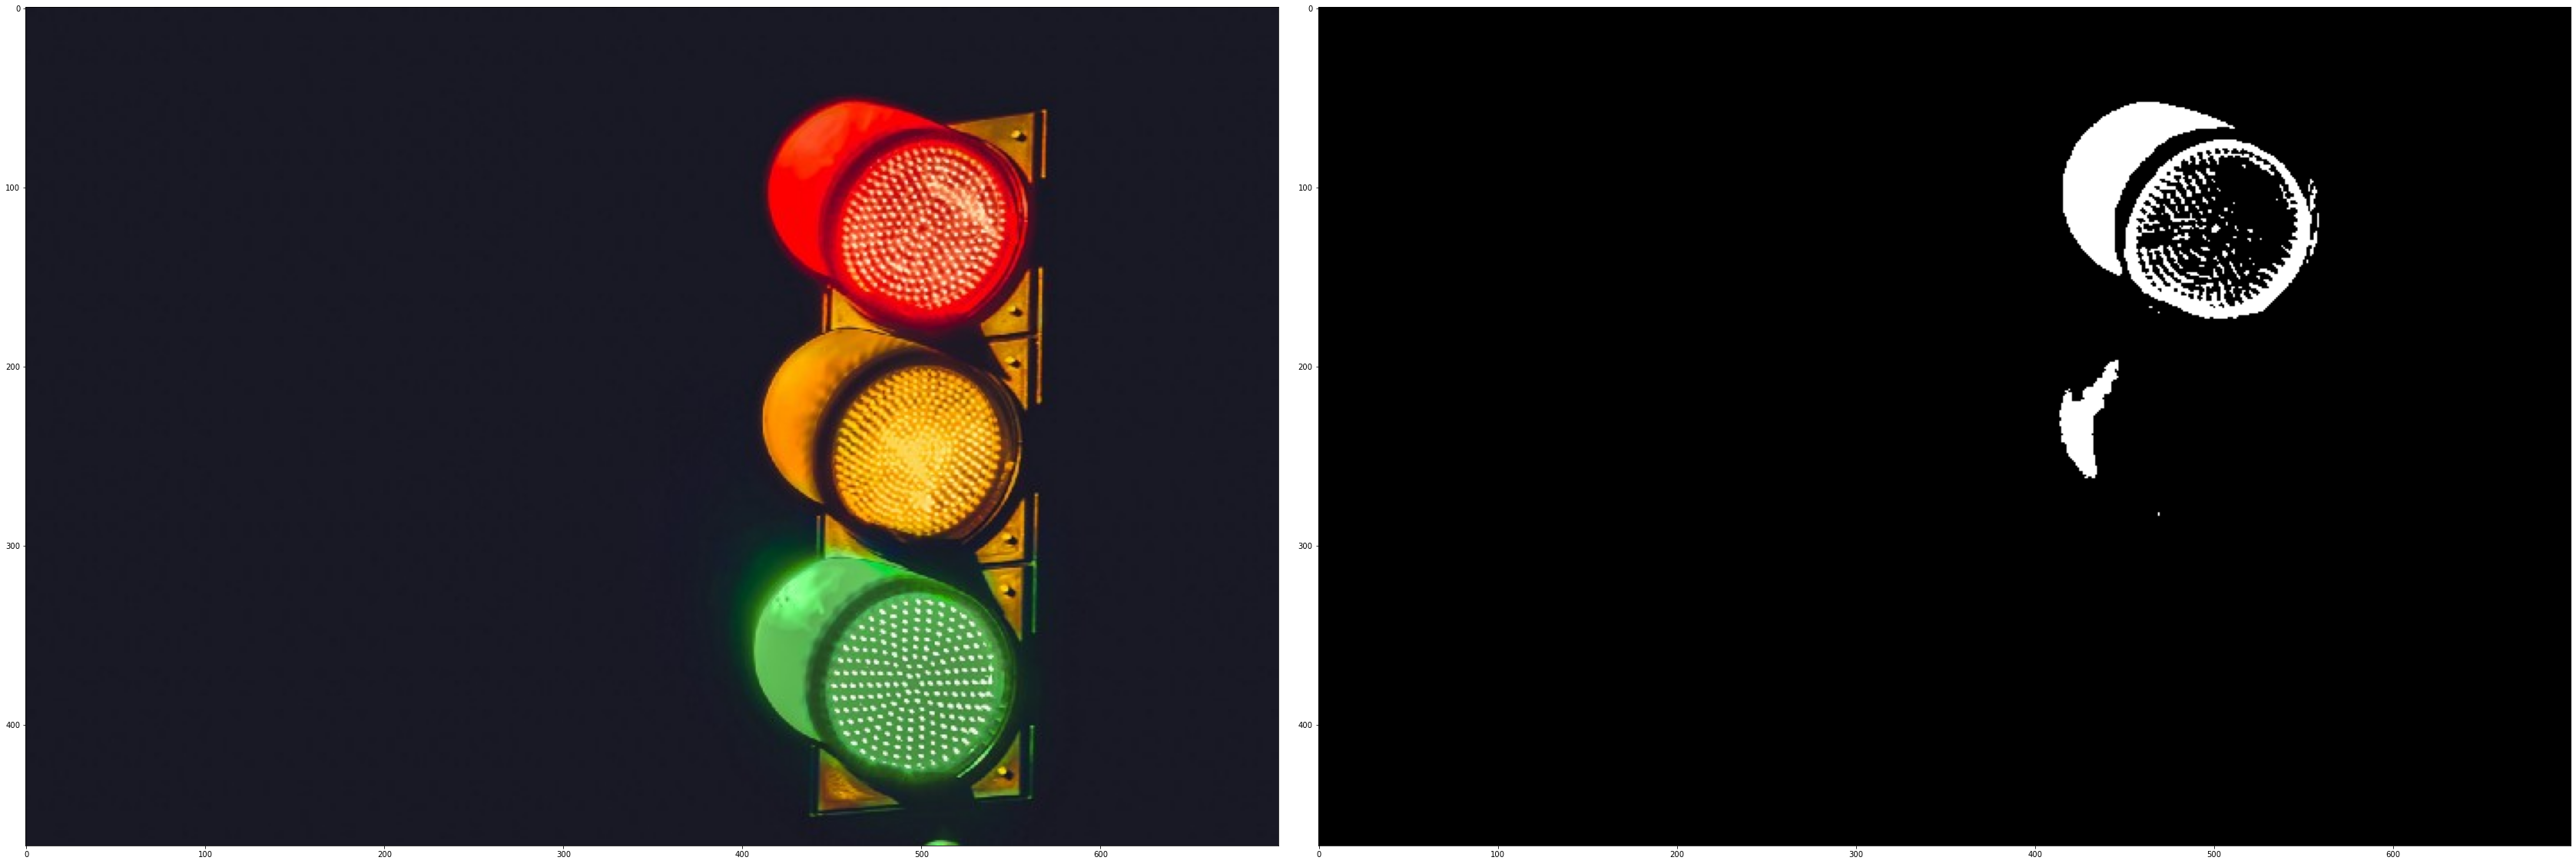

In [4]:
from sep.producers import Producer
class RedsProducer(Producer):
    def segmentation(self, input_data, input_tag):
        redness = np.abs(input_data[...,0] / 255.0 - np.mean(input_data, axis=-1) / 255.0)
        redness = redness > 0.45
        return redness
        
producer = RedsProducer("Reds")
segment, segment_tag = producer.calculate(image, tag)
print(segment_tag)
show_all(1, 2, image, segment);

## Calculate metrics on single image
In this section we show how to use only metrics part of SEP to assess results on the spot.
Here we additionally use regions to see how good is segmentation only near the boundaries of the ground truth. 

In [5]:
from sep.assessors.metricer import Metricer
from sep.assessors.metrics import IouMetric
metricer = Metricer()
metricer.metrics.append(IouMetric())

print("On entire image only:")
data_point_eval = metricer.evaluate_image(image, tag, segment, segment_tag, annotation)
data_point_eval

On entire image only:


,id,region,iou,seg_run_time,seg_run_fps,seg_producer_name,seg_producer_details
0,0,Entire image,0.220973,0.018056,55.38,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...


In [6]:
from sep.assessors.regions import EdgesRegion
metricer = Metricer()
metricer.metrics.append(IouMetric())
metricer.regions.append(EdgesRegion(edge_size=10, name="Edges 10px"))

print("On entire image and near the edges:")
data_point_eval = metricer.evaluate_image(image, tag, segment, segment_tag, annotation)
display(data_point_eval)
display(metricer.report_overall())

On entire image and near the edges:


,id,region,iou,seg_run_time,seg_run_fps,seg_producer_name,seg_producer_details
0,0,Entire image,0.220973,0.018056,55.38,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...
0,0,Edges 10px,0.330252,0.018056,55.38,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...


,id,iou,seg_run_time,seg_run_fps
region,,,,
Edges 10px,0,0.330252,0.018056,55.38
Entire image,0,0.220973,0.018056,55.38


### Dig deeper visually
Into regions used and ground truth vs segmentation visuals.

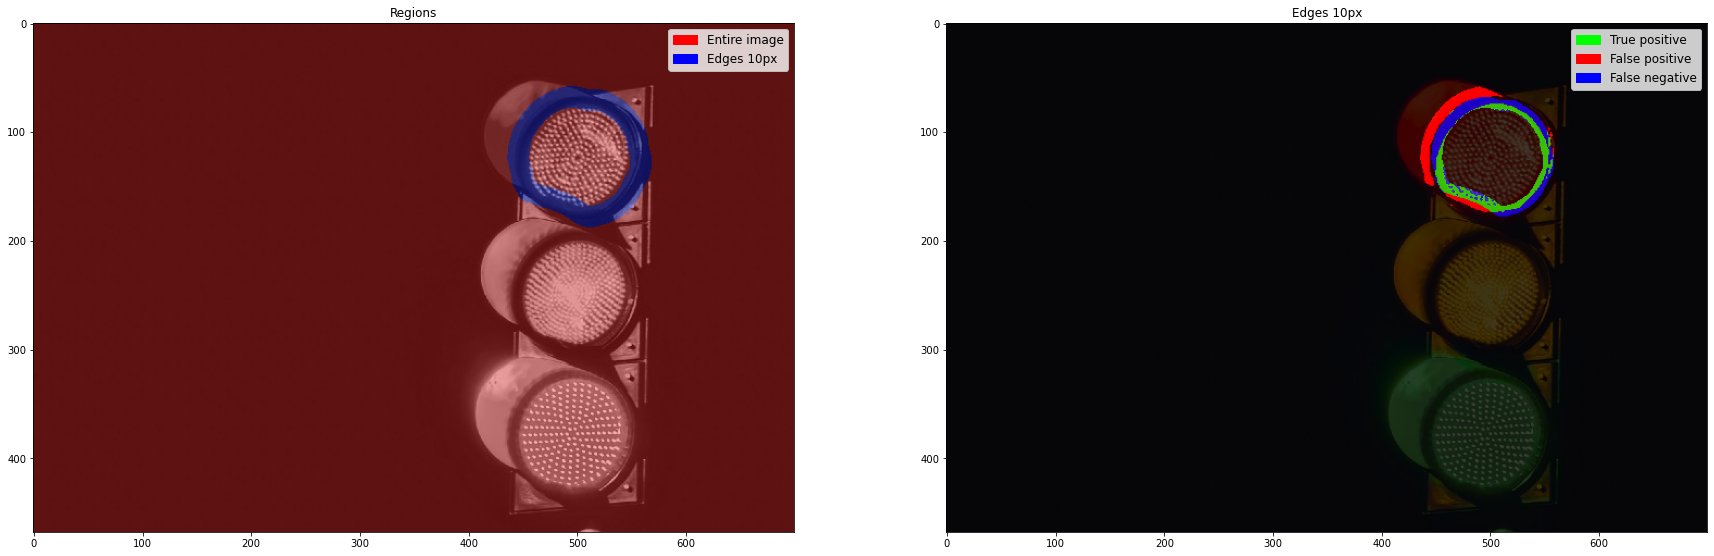

In [7]:
import sep._commons.imgutil as imgutil
importlib.reload(imgutil)
import sep._commons.visuals as visuals
importlib.reload(visuals)
import sep.inspect.metrics as inspect_metrics
importlib.reload(inspect_metrics)

# Show regions:
regionizers = metricer.regions
overlay, legend = regions_inspect.overlay_regions(image=image, 
                                                  regions=[r.extract_region(annotation) for r in regionizers], 
                                                  regions_names=[r.name for r in regionizers])

# Show ground truth vs segmentation comparison for edges region:
edges_regionizer = metricer.regions[-1]
seg_region = edges_regionizer.regionize(ground_truth=annotation, mask=segment)
gt_region = edges_regionizer.regionize(ground_truth=annotation, mask=annotation)
overlay_inspect, legend_inspect = metrics_inspect.overlay_visual_inspection(image, gt_region, seg_region)


regions_with_legend = visuals.show_with_legend([overlay, overlay_inspect], [legend, legend_inspect], 
                                               titles=["Regions", edges_regionizer.name], scale=30, legend_size=12)
display(regions_with_legend)

## Develop new metric
In this section you can develop a new metric that can fit your needs better.
It can be something fairly abstract, in case of the lights our purpose can be to find the center of the red light so that the metric will be the distance from the center of ground truth to the center of segmentation.

In [8]:
import scipy.ndimage
class CenterDistanceMetric(sep.assessors.metrics.Metric):
    def __init__(self):
        super().__init__("center_dist")

    def calculate(self, segmentation, ground_truth) -> float:
        center_seg = scipy.ndimage.center_of_mass(segmentation)
        center_true = scipy.ndimage.center_of_mass(ground_truth)
        dim_weight = (1/segmentation.shape[0]**2, 1/segmentation.shape[1]**2)
        return scipy.spatial.distance.euclidean(center_seg, center_true, w=dim_weight)

center_metric = CenterDistanceMetric()
center_metric.show(segment, annotation)

center_dist: 0.0518


In [9]:
from sep.assessors.metricer import Metricer
from sep.assessors.metrics import IouMetric
from sep.assessors.regions import EdgesRegion

metricer = Metricer()
metricer.metrics.append(IouMetric())
metricer.metrics.append(CenterDistanceMetric())
metricer.regions.append(EdgesRegion(edge_size=10, name="Edges 10px"))

data_point_eval = metricer.evaluate_image(image, tag, segment, segment_tag, annotation)
metricer.reset()
display(data_point_eval)

,id,region,iou,center_dist,seg_run_time,seg_run_fps,seg_producer_name,seg_producer_details
0,0,Entire image,0.220973,0.051756,0.018056,55.38,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...
0,0,Edges 10px,0.330252,0.024004,0.018056,55.38,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...


### Run new metric on entire dataset

In [10]:
import sep.evaluate
metricer.reset()
evaluation_results = sep.evaluate.evaluate(data_loader, producer, metricer, detailer=None, output_evalpath=None)
results = metricer.report_full()
display(results)
display(metricer.report_overall())

Evaluation of Reds on data from ImageLoader for: D:\Fafa\Drozdze\SEP\SEP\tests\input\basics\lights.
There are 4 images to evaluate on.


Reds: 100%|██████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


,id,region,iou,center_dist,seg_run_time,seg_run_fps,seg_producer_name,seg_producer_details,img_source
0,0,Entire image,0.220973,0.051756,0.015010,66.62,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,
1,0,Edges 10px,0.330252,0.024004,0.015010,66.62,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,
2,lights02,Entire image,0.220973,0.051756,0.014719,67.94,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,thenet
3,lights02,Edges 10px,0.330252,0.024004,0.014719,67.94,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,thenet
4,2,Entire image,0.658426,0.031707,0.011584,86.32,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,
5,2,Edges 10px,0.463101,0.066967,0.011584,86.32,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,
6,3,Entire image,0.827659,0.000491,0.044696,22.37,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,
7,3,Edges 10px,0.484157,0.006632,0.044696,22.37,Reds,<class '__main__.RedsProducer'> ({'name': 'Red...,


,iou,center_dist,seg_run_time,seg_run_fps
region,,,,
Edges 10px,0.401941,0.030402,0.021502,60.8125
Entire image,0.482008,0.033927,0.021502,60.8125


## Visualize and investigate the metrics
In this section you can visualize what are the metrics for segmentationon the entire dataset.

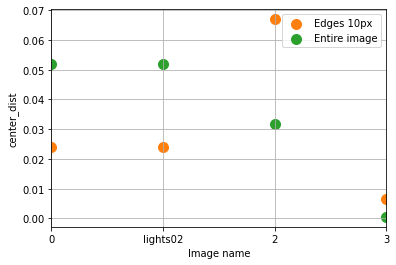

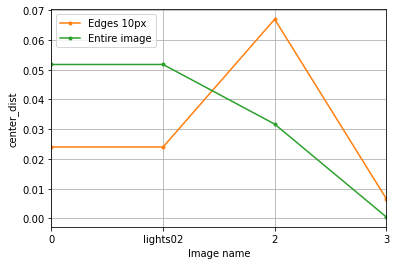

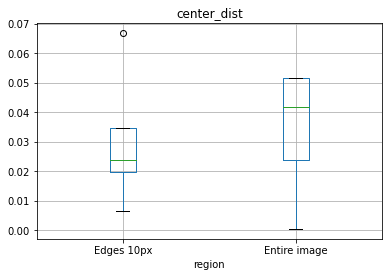

In [11]:
import pandas as pd
from matplotlib import cm
from sep._commons.utils import *

from sep.assessors.plott import Plotter

plotter = Plotter()
plotter.plot(results, groups_column='region', x_column='id', y_column='center_dist', 
             x_axis_label='Image name', s=100)  # specific size of the point
plotter.plot(results, groups_column='region', x_column='id', y_column='center_dist', 
             x_axis_label='Image name', as_lines=True, figsize=(10,5), linewidth=1)

plotter.summary_box(results, groups_column='region', y_column='center_dist');

## Comparison of two segmentators
Let us now create another segmentator and compare its quality on our lights dataset.

{'run_time': 0.02284895300000045, 'run_fps': 43.77, 'producer_name': 'Reds2.0', 'producer_details': "<class '__main__.RedsCleanProducer'> ({'name': 'Reds2.0'})"}


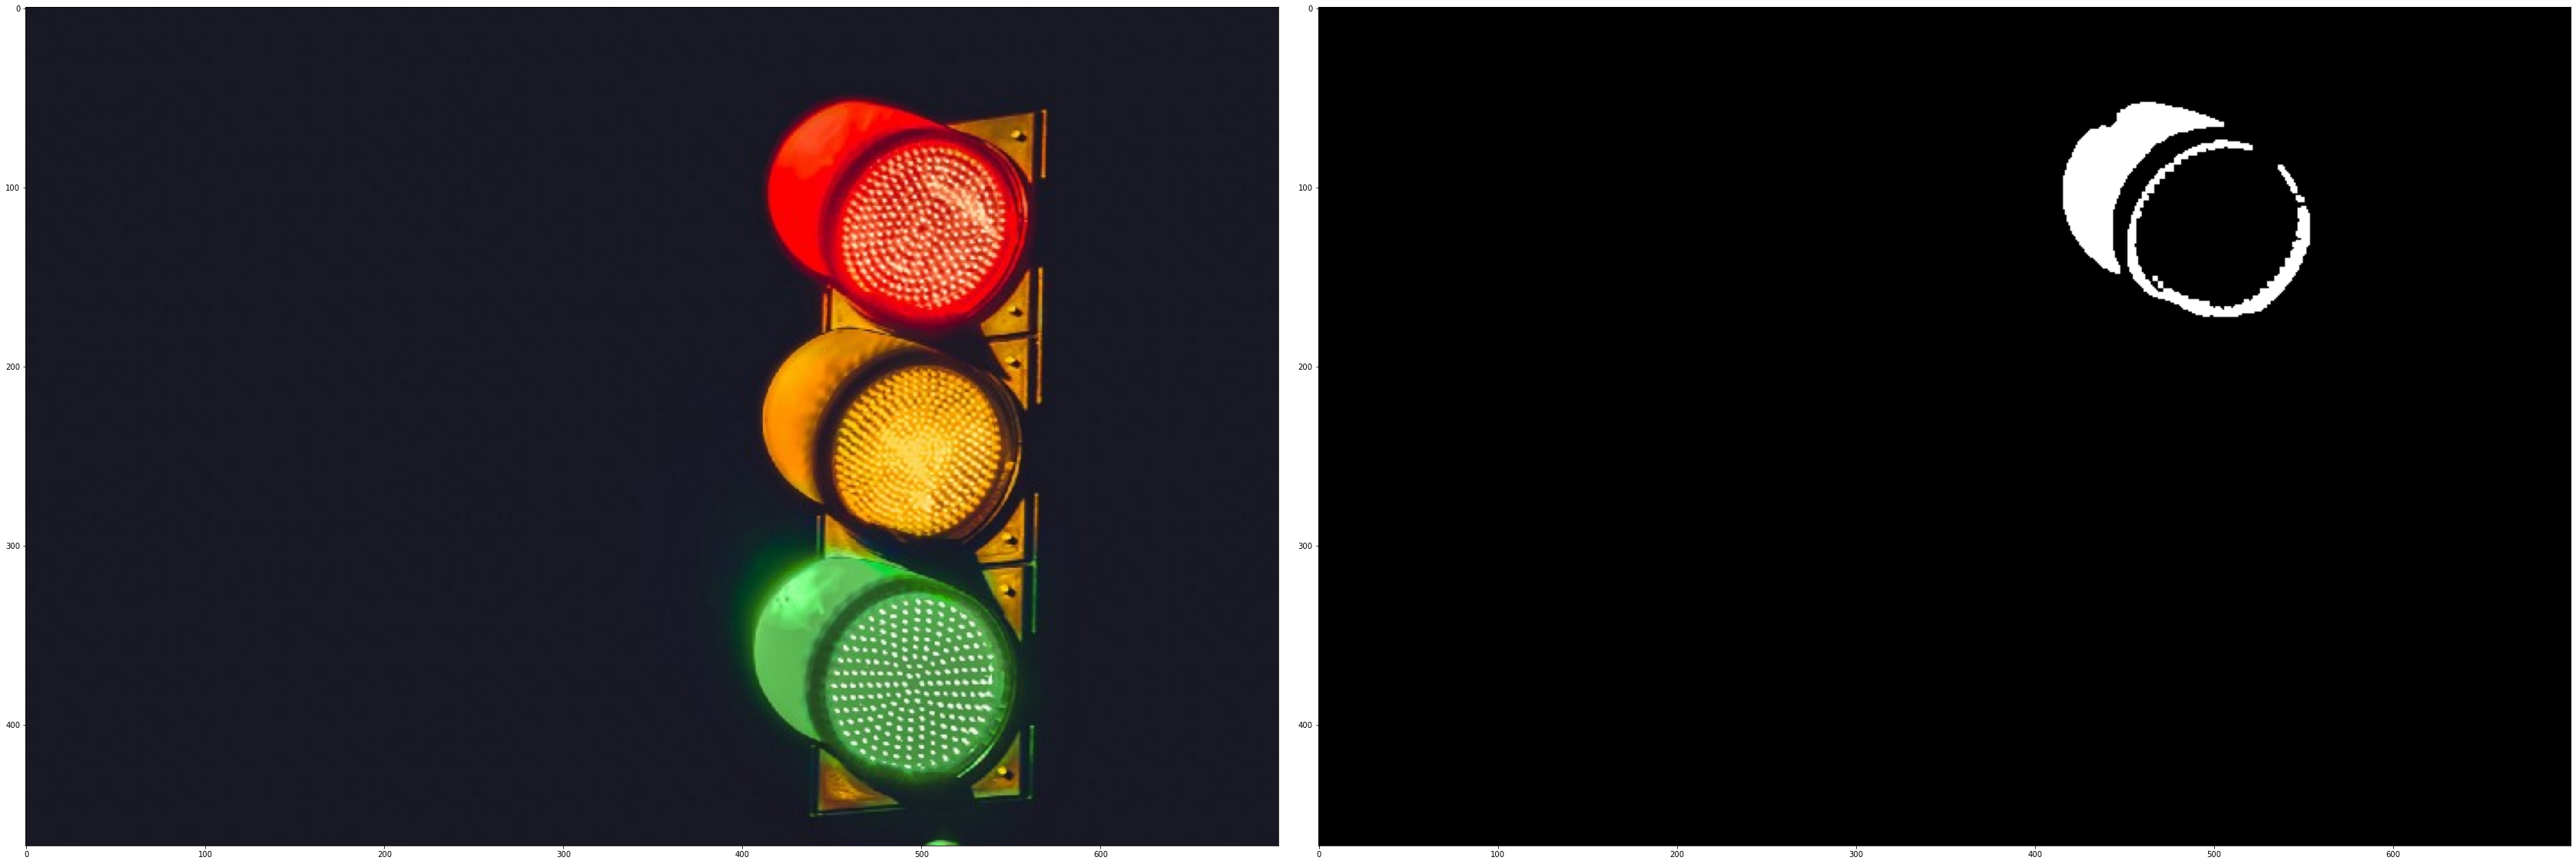

In [12]:
from sep.producers import Producer
class RedsCleanProducer(Producer):
    def segmentation(self, input_data, input_tag):
        redness = np.abs(input_data[...,0] / 255.0 - np.mean(input_data, axis=-1) / 255.0)
        redness = redness > 0.50
        cleaned = skimage.morphology.binary_opening(redness, selem=np.ones((3,3)))
        return cleaned
        
producer2 = RedsCleanProducer("Reds2.0")
segment2, segment2_tag = producer2.calculate(image, tag)
print(segment2_tag)
show_all(1, 2, image, segment2);

Comparison of 2 producers on data from ImageLoader for: D:\Fafa\Drozdze\SEP\SEP\tests\input\basics\lights.


Reds2.0: 100%|███████████████████████████████████| 4/4 [00:00<00:00, 18.68it/s]


,,iou,seg_run_time,seg_run_fps
producer,region,,,
Reds,Entire image,0.482008,0.023250,57.73750
Reds2.0,Entire image,0.387280,0.028987,47.71125


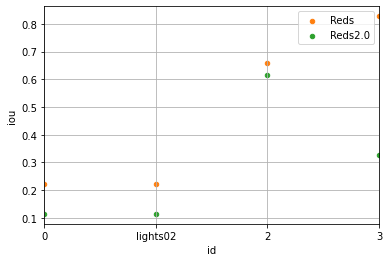

In [13]:
import sep.evaluate

metricer = Metricer()
metricer.metrics.append(IouMetric())
comparison_results = sep.evaluate.compare(data_loader, [producer, producer2], metricer, detailer=None, output_evalpath=None)
display(comparison_results)

plotter = Plotter()
plotter.plot(metricer.report_full(), groups_column='seg_producer_name', x_column='id', y_column='iou'); 